In [83]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def analytical_solution(g, w0, t):

    assert g <= w0
    w = np.sqrt(w0**2-g**2)
    phi = np.arctan(-g/w)
    A = 1/(2*np.cos(phi))
    cos = tf.math.cos(phi+w*t)
    sin = tf.math.sin(phi+w*t)
    exp = tf.math.exp(-g*t)
    x  = exp*2*A*cos
    return x

def MLP(n_input, n_output, n_neuron, n_layer, act_fn='tanh'):
    tf.random.set_seed(1234)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units=n_neuron,
            activation=act_fn,
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
            input_shape=(n_input,),
            name='H1')
    ])
    for i in range(n_layer-1):
        model.add(
            tf.keras.layers.Dense(
                units=n_neuron,
                activation=act_fn,
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                name='H{}'.format(str(i+2))
            ))
    model.add(
        tf.keras.layers.Dense(
            units=n_output,
            name='output'
        ))
    return model

class EarlyStopping:

    def __init__(self, patience=10, verbose=0):

        self.epoch = 0 # 監視中のエポック数のカウンターを初期
        self.pre_loss = float('inf') # 比較対象の損失を無限大'inf'で初期化
        self.patience = patience # 監視対象のエポック数をパラメーターで初期化
        self.verbose = verbose # 早期終了メッセージの出力フラグをパラメーターで初期化

    def __call__(self, current_loss):

        if self.pre_loss < current_loss: # 前エポックの損失より大きくなった場合
            self.epoch += 1 # カウンターを1増やす

            if self.epoch > self.patience: # 監視回数の上限に達した場合
                if self.verbose:  # 早期終了のフラグが1の場合
                    print('early stopping')
                return True # 学習を終了するTrueを返す

        else: # 前エポックの損失以下の場合
            self.epoch = 0 # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新す

        return False


class PhysicsInformedNNs():

    def __init__(self, n_input, n_output, n_neuron, n_layer, epochs, act_fn='tanh'):
        self.n_input = n_input
        self.n_output = n_output
        self.n_neuron = n_neuron
        self.n_layer = n_layer
        self.epochs = epochs
        self.act_fn = act_fn

    def build(self, optimizer, loss_fn, early_stopping):
        self._model = MLP(self.n_input, self.n_output, self.n_neuron, self.n_layer, self.act_fn)
        self._optimizer = optimizer
        self._loss_fn = loss_fn
        self._early_stopping = early_stopping
        return self

    def train_step(self, t_data, x_data, t_pinn, c, k, loop):
        with tf.GradientTape() as tape_total:
            tape_total.watch(self._model.trainable_variables)
            x_pred = self._model(t_data)
            loss1 = self._loss_fn(x_pred, x_data)
            loss1 = tf.cast(loss1, dtype=tf.float32)

            with tf.GradientTape() as tape2:
                tape2.watch(t_pinn)
                with tf.GradientTape() as tape1:
                    tape1.watch(t_pinn)
                    x_pred_pinn = self._model(t_pinn)
                dx_dt = tape1.gradient(x_pred_pinn, t_pinn)
            dx_dt2 = tape2.gradient(dx_dt, t_pinn)

            dx_dt  = tf.cast(dx_dt, dtype=tf.float32)
            dx_dt2 = tf.cast(dx_dt2, dtype=tf.float32)
            x_pred_pinn = tf.cast(x_pred_pinn, dtype=tf.float32)

            loss_physics = dx_dt2 + c * dx_dt + k * x_pred_pinn
            loss2 = 5.0e-6 * self._loss_fn(loss_physics, tf.zeros_like(loss_physics))
            loss2 = tf.cast(loss2, dtype=tf.float32)
         
            loss = loss1 + loss2
            if loop % 300 ==0:         
                print("loss: ",loss.numpy(), "train_step:",loop)

        self._optimizer.minimize(loss, self._model.trainable_variables, tape=tape_total)
        self._loss_values.append(loss)
        return self

    def train(self, t, x, t_data, x_data, t_pinn, c, k):
        self._loss_values = []
        self.loop = 0
        for i in range(self.epochs):
            self.loop += 1
            self.train_step(t_data, x_data, t_pinn, c, k, self.loop)
            if self._early_stopping(self._loss_values[-1]):
                break


In [108]:
if __name__ == "__main__":

    ################ Data-driven neural networks ################

    g, w0 = 3, 28
    c, k = 2*g, w0**2

    t = tf.linspace(0,1,300)
    t = tf.reshape(t,[-1,1])

    x = analytical_solution(g, w0, t)
    x = tf.reshape(x,[-1,1])
    ############## Physics-informed neural networks ##############

    t_pinn = tf.linspace(0,1,50)
    t_pinn = tf.reshape(t_pinn,[-1,1])

    # Random data points
    random_list = [0,299]
    t_data = tf.gather(t, random_list)
    x_data = tf.gather(x, random_list)

    PINNs = PhysicsInformedNNs(1,1,48,5,25000)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss_fn = tf.keras.losses.MeanSquaredError()
    early_stopping = EarlyStopping(patience=250,verbose=1)
    PINNs.build(optimizer, loss_fn, early_stopping)
    PINNs.train(t, x, t_data, x_data, t_pinn, c, k)

loss:  0.02709574 train_step: 300
loss:  0.015870383 train_step: 600
loss:  0.005338027 train_step: 900
loss:  0.0034190817 train_step: 1200
early stopping


In [109]:
t_test = tf.linspace(0,1,80)
x_test = PINNs._model.predict(t_test)

3/3 [==============================] - 0s 1000us/step


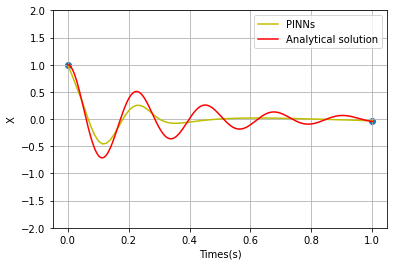

In [110]:

plt.plot(t_test, x_test, label="PINNs", c="y")

plt.plot(t,x,label="Analytical solution",c="r" )

plt.scatter(t_data, x_data)
plt.xlabel("Times(s)")
plt.ylabel("X")
plt.grid(True)
plt.ylim(-2.0, 2.0)
plt.legend()
plt.show()